In [1]:
import jupyter_black

from PIL import Image
import os, shutil
import sys
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

jupyter_black.load()


if "/usr/src" not in sys.path:
    sys.path.append("/usr/src")

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.utils import save_image

In [3]:
# Custom modules
import models.unet as unet
import utils.opencv

In [9]:
t1 = torch.rand(1, 128, 16, 16)
t2 = torch.rand(1, 128, 16, 16)

t = torch.cat((t1, t2), dim=1)
t.shape

torch.Size([1, 256, 16, 16])

In [4]:
with Image.open("/usr/src/data/part_substrates/part_substrate_0.png") as image:
    tensor = transforms.Compose(
        [transforms.CenterCrop((128, 128)), transforms.ToTensor()]
    )(image)
    tensor = tensor.unsqueeze(0)

    model = unet.UNet(resolution=(128, 128), in_channels=1)
    tensor_unet = model(tensor)

torch.Size([1, 128, 16, 16]) torch.Size([1, 128, 16, 16])
torch.Size([1, 256, 16, 16])


In [5]:
tensor_unet.shape

torch.Size([1, 128, 16, 16])

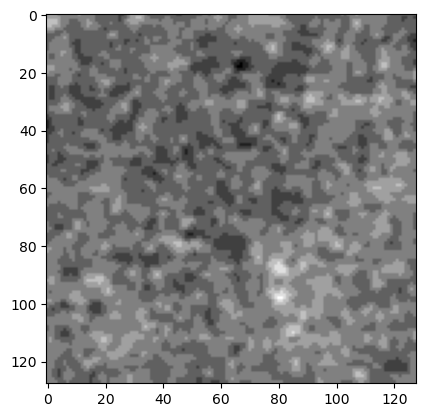

In [38]:
plt.imshow(tensor.squeeze(), cmap="gray")

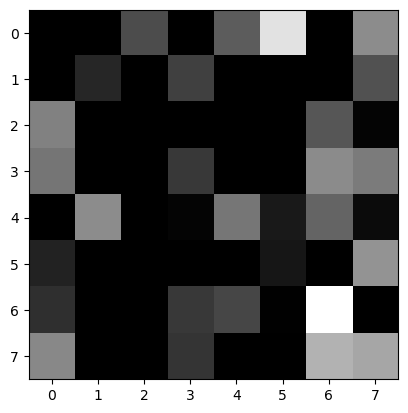

In [39]:
plt.imshow(tensor_unet.squeeze()[0, :, :].detach().numpy(), cmap="gray")

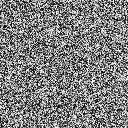

In [23]:
pil_image = transforms.ToPILImage()(image.view(-1, 128, 128))
pil_image.show()
pil_image_unet = transforms.ToPILImage()(image_after_unet.squeeze()[0, :, :])

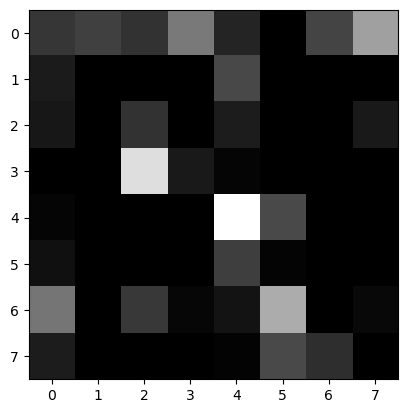

In [26]:
plt.imshow(image_after_unet.squeeze()[0, :, :].detach().numpy(), cmap="gray")

In [ ]:
source_dir = "C:/Programs Python/IOC/valid_bf_imgs_dir_png"

In [33]:
def image_to_tensor(img: Image.Image) -> torch.Tensor:
    tensor = torch.tensor(np.array(img) / 255)
    return tensor[None, None, :, :]


def tensor_to_image(tensor: torch.Tensor):
    image = tensor.squeeze()
    return Image.fromarray(image.numpy())

In [70]:
# Forward diffusion

def alpha_t(beta_t: float):
    return 1 - beta_t


def alpha_t_cumprod(alpha_t_arr: torch.Tensor):
    res = 1
    for alpha_s in alpha_t_arr:
        res *= alpha_s
    return res


def sample_x_t(x_0, t: int, alphas_cumprod):
    eps = torch.randn_like(x_0)
    alpha_t_cumprod = alphas_cumprod[t]
    return torch.sqrt(alpha_t_cumprod) * x_0 + torch.sqrt(1 - alpha_t_cumprod) * eps

In [76]:
T = 10
betas = torch.linspace(0.0001, 0.02, T)
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

noised_images = []

with Image.open("../data/source_images/valid_img_0.png") as image:
    x_0 = transforms.ToTensor()(image)
    image.save("Step_0.png")
    for t in range(1, T):
        x_t = sample_x_t(x_0, t, alphas_cumprod)
        image_x_t = transforms.ToPILImage()(x_t)
        image_x_t.save(f"Step_{t}.png")
        # noised_images.append(tfs.ToPILImage()(x_t))

In [75]:
with Image.open(source_dir + "/valid_img_0.png") as image:
    x0 = transforms.ToTensor()(image).unsqueeze(0)
    x0_down = nn.Sequential(unet.DoubleConv(1, 64), unet.DowmSampling(64, 128))(x0)

torch.Size([10])

In [ ]:
# Collect photos
for file in os.listdir('raw_support_data'):
    if file[-3:] == 'tif':
        shutil.copyfile(f'raw_support_data/{file}', f'substrates/{file}')

In [ ]:
# crop photos

for idx, file in enumerate(os.listdir('substrates')):
    image = cv.imread(f'substrates/{file}', 0)
    if idx == 0:
        crop_size = utils.opencv.get_size_for_crop(image)
    image = utils.opencv.delete_description(image, crop_size)
    cv.imwrite(f'substrates/{file}', image)

In [ ]:
my_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.5, contrast=0.5),
    transforms.RandomCrop(size=(128, 128)),
    transforms.ToTensor()
])

In [ ]:
part_substrate_dir = 'part_substrates'

In [ ]:
def get_part_substrates(image: torch.Tensor, file_idx: int, part_size=(128, 128), stride=128):
    count = 0
    height, width = image.shape[-2], image.shape[-1]
    for i in range(width // stride):
        for j in range(height // stride):
            part_image = image[:, j*stride : j*stride + part_size[0], i*stride : i*stride + part_size[1]]
            save_image(part_image, f'{part_substrate_dir}/part_substrate_{file_idx}_{count}.tif')
            count += 1

In [ ]:
for idx, file in enumerate(os.listdir('substrates')):
    with Image.open(f'substrates/{file}') as image:
        tensor_image = transforms.ToTensor()(image)
        get_part_substrates(tensor_image, idx)

In [ ]:
fig, axes = plt.subplots(2, 5)

for ax, img in zip(axes.flat, noised_images):
    ax.imshow(img, cmap="gray", vmin=0, vmax=255)